In [ ]:
import torch
import torch.nn as nn
import numpy as np
import os
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image, ImageOps, ImageEnhance
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
opt = {
    'image_size': 234,
    'is_grayscale': False,
}

In [ ]:
def load_image(path):
    # Opening image
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    # Enhancing image
    im = ImageEnhance.Contrast(ImageOps.autocontrast(im)).enhance(2.0)
    # Contrast adjustment
    im = ImageOps.autocontrast(im)
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    # im = im/256
    im = transforms.ToTensor()(im)
    return im

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(5,5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
dir_path = '/content/drive/MyDrive/SMAI_Project/train_images'
files = sorted(os.listdir(dir_path))
files = files[:1000]

In [ ]:
image_list = []
for filename in tqdm(files):
    if filename.endswith(".png"):
      image_list.append(os.path.join(dir_path,filename))

100%|██████████| 1000/1000 [00:00<00:00, 84535.31it/s]


In [ ]:
images = torch.cat([torch.unsqueeze(load_image(image), 0) for image in tqdm(image_list)], dim=0)

100%|██████████| 1000/1000 [04:05<00:00,  4.08it/s]


In [ ]:
images.shape

torch.Size([1000, 3, 234, 234])

Sample images


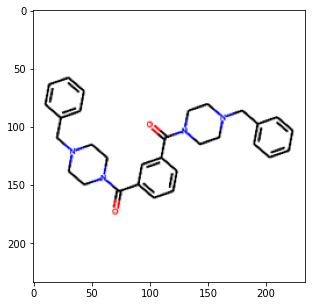

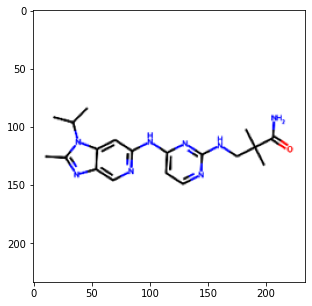

In [ ]:
print("Sample images")
imshow(images[0])
imshow(images[5])

In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 582 kB 5.2 MB/s 
     |████████████████████████████████| 596 kB 44.1 MB/s 
     |████████████████████████████████| 136 kB 51.3 MB/s 
     |████████████████████████████████| 408 kB 47.2 MB/s 
     |████████████████████████████████| 1.1 MB 35.9 MB/s 
     |████████████████████████████████| 271 kB 48.3 MB/s 
     |████████████████████████████████| 144 kB 50.6 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pytorch_lightning as pl
class Image2CDDD(pl.LightningModule):
    def __init__(self):
        super(Image2CDDD, self).__init__()
        # Input size: [batch, 3, 500, 500]

        self.network = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size = 7, stride=3, padding = 4),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size = 5, stride=1, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 384, kernel_size = 5, stride=1, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(384, 384, kernel_size = 3, stride=1, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size = 3, stride=1, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(384, 512, kernel_size = 3, stride=1, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size = 3, stride=1, padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size = 3, stride=1, padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Flatten(),

            nn.Linear(512*9*9, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.0),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.0),
            nn.Linear(4096, 512),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
model = Image2CDDD()
model.eval()
model.to(device)

learning_rate = 1e-4

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)

In [ ]:
cddd = torch.randn(images.shape[0], 512)
cddd.shape

torch.Size([1000, 512])

In [ ]:
dataset = []
for i in range(len(images)):
  dataset.append([images[i], cddd[i]])
train_size = int(0.8 * len(images))
test_size = len(images) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
n_epochs = 10
gc.collect()
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)

for epoch in range(n_epochs):
  running_loss = 0.0
  for i, (batch_x, batch_y) in enumerate(trainloader, 0):
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)

    outputs = model(batch_x)
    loss = criterion(outputs, batch_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.data
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0
	
print('Finished Training')
print('Saving Model...')
torch.save(model.state_dict(), "image2mol.pt")

Finished Training
Saving Model...
